# Analysis of NIST Ground dataset

This notebook uses PVPRO to analyze the NIST dataset.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import json

# PVInsight Code Imports
from sys import path
from solardatatools import DataHandler
# from statistical_clear_sky import IterativeFitting

from glob import glob
from pickle import load, dump
from pvlib.pvsystem import retrieve_sam

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import sys

import mosek


In [2]:
import jupyterlab
if jupyterlab.__version__.split(".")[0] == "3":
    from jupyter_server import serverapp as app
    key_srv_directory = 'root_dir'
else : 
    from notebook import notebookapp as app
    key_srv_directory = 'notebook_dir'
import urllib
import json
import os
import ipykernel

def notebook_path(key_srv_directory, ):
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in app.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv[key_srv_directory],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

nb_path = notebook_path(key_srv_directory)

pvpro_path = os.path.split(os.path.split(nb_path)[0])[0]
pvpro_path


'/Users/XChen9/Codes/Github/pvpro'

In [3]:
sys.path.append(pvpro_path)

# sys.path.append('pvpro')
from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor

from pvpro.plotting import plot_Vmp_Imp_scatter, plot_poa_Imp_scatter, plot_results_timeseries
from pvanalytics.features import clipping

from pvpro.postprocess import analyze_yoy
from pvpro.plotting import plot_results_timeseries

import seaborn as sns

from datetime import datetime


## Load data

Load dataframe and info files.

In [4]:
system = 'onemin-Ground'
dfi = pd.read_pickle('data/nist01_onemin-Ground.pkl')
df = dfi[::5]

In [44]:
len(dfi), len(df)

(2103810, 2000)

In [43]:
dfi

,SEWSPOAIrrad_Wm2_Avg,SEWSAmbientTemp_C_Avg,InvPDC_kW_Avg,AmbTemp_C_Avg,ShuntCurrent_A_Avg_6,RTD_C_Avg_5,InvVDCin_Avg,RTD_C_Avg_9,RTD_C_Avg_7,InvIb_Avg,...,InvSystemFault_Max,ShuntCurrent_A_Avg_4,InvMainFault_Max,ShuntCurrent_A_Avg_7,RTD_C_Avg_6,RTD_C_Avg_4,RefCell1_Wm2_Avg,Pyra2_Wm2_Avg,ShuntPDC_kW_Avg_4,InvTempFault_Max
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.038,-3.404,0.0,-2.612,0.005,-9.48,8.83,-8.87,-9.43,0.0,...,0.0,0.001,0.0,0.007,-8.61,-8.89,0.104,-4.393416,0.0,0.0
2015-01-01 00:01:00,-0.038,-3.107,0.0,-2.387,0.005,-9.38,8.84,-8.79,-9.38,0.0,...,0.0,0.001,0.0,0.007,-8.53,-8.79,0.110,-4.393416,0.0,0.0
2015-01-01 00:02:00,-0.038,-3.169,0.0,-2.401,0.005,-9.38,8.84,-8.80,-9.38,0.0,...,0.0,0.001,0.0,0.007,-8.42,-8.66,0.106,-4.393416,0.0,0.0
2015-01-01 00:03:00,-0.038,-3.230,0.0,-2.405,0.005,-9.39,8.83,-8.77,-9.36,0.0,...,0.0,0.001,0.0,0.007,-8.48,-8.73,0.104,-4.393416,0.0,0.0
2015-01-01 00:04:00,-0.038,-3.310,0.0,-2.417,0.005,-9.44,8.82,-8.71,-9.48,0.0,...,0.0,0.001,0.0,0.006,-8.61,-8.84,0.104,-4.393416,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:55:00,-0.038,9.710,0.0,10.090,0.000,9.56,8.76,9.65,9.95,0.0,...,0.0,0.000,0.0,0.001,9.79,9.48,0.306,-2.065799,0.0,0.0
2018-12-31 23:56:00,-0.038,9.680,0.0,10.070,0.000,9.58,8.85,9.66,9.95,0.0,...,0.0,0.000,0.0,0.001,9.76,9.48,0.306,-2.065799,0.0,0.0
2018-12-31 23:57:00,-0.038,9.720,0.0,10.100,0.000,9.66,8.83,9.67,9.95,0.0,...,0.0,0.000,0.0,0.000,9.76,9.60,0.306,-2.065799,0.0,0.0


In [6]:
dfi.keys()

Index(['SEWSPOAIrrad_Wm2_Avg', 'SEWSAmbientTemp_C_Avg', 'InvPDC_kW_Avg',
       'AmbTemp_C_Avg', 'ShuntCurrent_A_Avg_6', 'RTD_C_Avg_5', 'InvVDCin_Avg',
       'RTD_C_Avg_9', 'RTD_C_Avg_7', 'InvIb_Avg', 'RTD_C_Avg_1', 'TIMESTAMP',
       'ShuntCurrent_A_Avg_1', 'InvSystemWarn_Max', 'InvPVMStatus_Max',
       'WindSpeedAve_ms', 'RTD_C_Avg_10', 'RTD_C_Avg_8', 'InvIc_Avg',
       'InvVc_Avg', 'RTD_C_Avg_3', 'ShuntPDC_kW_Avg_1', 'ShuntCurrent_A_Avg_5',
       'ShuntPDC_kW_Avg_6', 'InvPAC_kW_Avg', 'RTD_C_Avg_2', 'InvVa_Avg',
       'ShuntPDC_kW_Avg_5', 'InvVb_Avg', 'ShuntPDC_kW_Avg_3',
       'InvOpStatus_Avg', 'Pyra1_Wm2_Avg', 'SEWSModuleTemp_C_Avg',
       'ShuntPDC_kW_Avg_7', 'ShuntCurrent_A_Avg_3', 'ShuntPDC_kW_Avg_2',
       'InvIa_Avg', 'InvIDCin_Avg', 'ShuntCurrent_A_Avg_2',
       'InvDriveFault_Max', 'InvSystemFault_Max', 'ShuntCurrent_A_Avg_4',
       'InvMainFault_Max', 'ShuntCurrent_A_Avg_7', 'RTD_C_Avg_6',
       'RTD_C_Avg_4', 'RefCell1_Wm2_Avg', 'Pyra2_Wm2_Avg', 'ShuntPDC_kW_A

Choose inverter number for analysis.

Input Metadata

In [7]:
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6
delta_T = 3

Get module from CEC database. Or can enter parameters manually. Only need a dictionary with 'alpha_sc' (units of A/C), 'R_sh_ref' and 'N_s'.

In [8]:
cec = retrieve_sam('CECmod')
module = cec['Sharp_NU_U235F2']
module['alpha_sc'] = alpha_isc

In [9]:
module

Technology            Mono-c-Si
Bifacial                      0
STC                       235.2
PTC                       211.9
A_c                       1.573
Length                    1.618
Width                     0.972
N_s                          60
I_sc_ref                    8.6
V_oc_ref                   37.0
I_mp_ref                   7.84
V_mp_ref                   30.0
alpha_sc               0.004558
beta_oc                -0.12173
T_NOCT                     45.4
a_ref                  1.572369
I_L_ref                8.628778
I_o_ref                     0.0
R_s                    0.300444
R_sh_ref              89.785065
Adjust                14.428038
gamma_r                  -0.458
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Sharp_NU_U235F2, dtype: object

## Initiate PVPRO

Instantiate PVPRO data handler.

In [10]:
pre = Preprocessor(df,
                   voltage_dc_key=voltage_dc_key,
                   current_dc_key=current_dc_key,
                   temperature_module_key=temperature_module_key,
                   irradiance_poa_key=irradiance_poa_key,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   solver=None
                   )

In [11]:
pre.calculate_cell_temperature(delta_T=3)

Cell temperature assigned to 'temperature_cell'


In [12]:
method='sdt'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()


Fixing daylight savings time shift...
Running solar data tools...
total time: 13.45 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.52s
Cleaning                   5.35s
Filtering/Summarizing      5.56s
    Data quality           0.23s
    Clear day detect       0.18s
    Clipping detect        4.24s
    Capacity change detect 0.90s
Extra Column Processing    0.03s


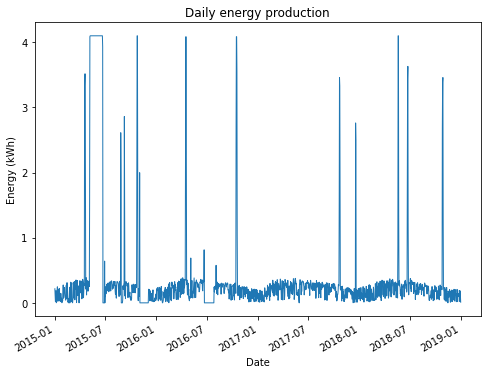

In [13]:
fig = pre.dh.plot_daily_energy()

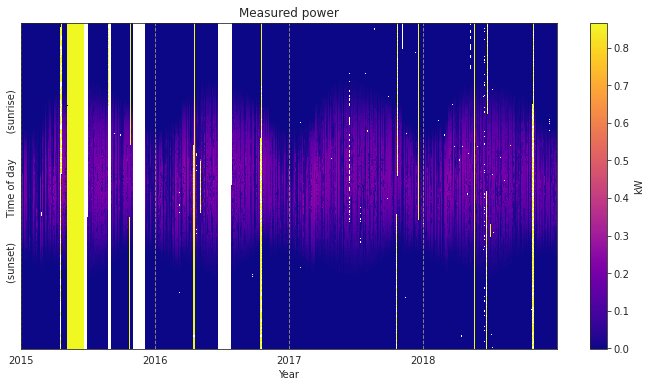

In [14]:
if method=='sdt':
    fig = pre.dh.plot_heatmap()

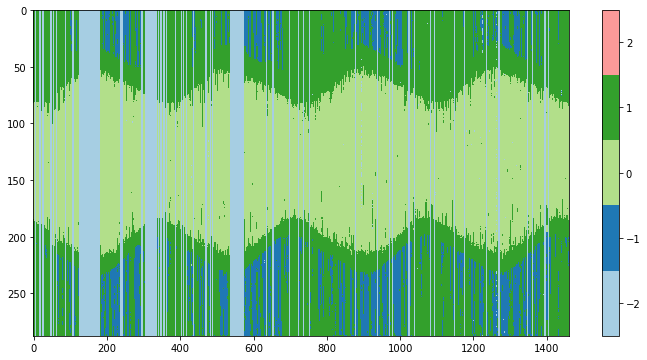

In [15]:
if method=='sdt':
    fig = pre.plot_operating_cls()

In [16]:
filter_IE = pre.find_current_irradiance_outliers(points_per_iteration=5000)

In [17]:
max_k = len(filter_IE['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
@interact
def show_inbounds_IE(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_IE['lower_iter_idx'][k], filter_IE['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and(np.logical_not(filter_IE['outliers'][cax]), filter_IE['boolean_mask'][cax])
    outliers =  np.logical_and(filter_IE['outliers'][cax],filter_IE['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,1200,5)
    fig = plt.figure()
    plt.scatter(poa[cax][inbounds],current[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_IE['huber'][k].coef_ * x_smooth + filter_IE['huber'][k].intercept_,'g')

    plt.scatter(poa[cax][outliers], current[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('POA (W/m^2)')
    plt.ylabel('Current (A)')
    plt.xlim([0,1200])
    plt.ylim([0,11])
    plt.legend()
    plt.show()



interactive(children=(IntSlider(value=39, description='k', max=79), Output()), _dom_classes=('widget-interact'…

In [18]:
filter_TV = pre.find_temperature_voltage_outliers(voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=100000,
                                                 epsilon=3)

In [19]:
max_k = len(filter_TV['upper_iter_idx'])-1
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
voltage = pre.df[pre.voltage_dc_key]/pre.modules_per_string
temperature_cell = pre.df['temperature_cell']
@interact
def show_inbounds_TV(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_TV['lower_iter_idx'][k], filter_TV['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and.reduce((
        np.logical_not(filter_TV['outliers'][cax]),
        filter_TV['boolean_mask'][cax]
    ))
    outliers =  np.logical_and(filter_TV['outliers'][cax],        filter_TV['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,70,2)
    fig = plt.figure()
    plt.scatter(temperature_cell[cax][inbounds],voltage[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_TV['huber'][k].coef_ * x_smooth + filter_TV['huber'][k].intercept_,'g')
    print(filter_TV['huber'][k].coef_)

    plt.scatter(temperature_cell[cax][outliers], voltage[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('Cell Temperature (C)')
    plt.ylabel('Voltage (V)')
    plt.xlim([-20,70])
    plt.ylim([0,70])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=1, description='k', max=2), Output()), _dom_classes=('widget-interact',)…

In [20]:
filter_clear_time=True
if filter_clear_time:
    pre.find_clear_times_sdt()

No SCSF model detected. Fitting now...
----------------------
SCSF Problem Setup
----------------------
Matrix Size: 288 x 1461 = 420768 power measurements
Sparsity: 85.72%
60076 non-zero measurements under clear conditions
Model size: 288 x 6 + 6 x 1461 = 10494 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 1.509e+08, f1: 5.674e+05, f2: 8.292e+02, f3: 1.061e+08, f4: 4.423e+07
    Minimizing left matrix


/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:167: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 2.367e+05, f1: 2.300e+05, f2: 3.379e+02, f3: 6.355e+03, f4: 2.164e-06
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 2.262e+05, f1: 2.194e+05, f2: 2.462e+02, f3: 6.512e+03, f4: 2.995e-07
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 2.257e+05, f1: 2.189e+05, f2: 2.443e+02, f3: 6.535e+03, f4: 1.667e-07
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 2.256e+05, f1: 2.188e+05, f2: 2.510e+02, f3: 6.531e+03, f4: 1.192e-07
Minimization complete in 5.19 minutes


In [21]:
power = pre.df['power_dc']
@interact
def inspect_clear_time(plot_start=(0,len(power),100)):
    plt.figure(figsize=(11,3))
    N = 300
    cax = np.arange(plot_start,plot_start+N).astype('int')
#     mask = pre.df['monotonic'][cax]
    plt.plot(pre.df.index[cax], power[plot_start:plot_start+N])
#     plt.plot(pre.df.index[cax][mask], power[cax][mask],
#             'r.',label='Monotonic')
    if 'clear_time' in pre.df:
        mask = pre.df['clear_time'][cax]
        plt.plot(pre.df.index[cax][mask], power[cax][mask],
            'r.',label='Clear time SDT')
    plt.legend()
    plt.ylabel('Power per module (W)')
    plt.show()

interactive(children=(IntSlider(value=211000, description='plot_start', max=422063, step=100), Output()), _dom…

In [22]:
pre.dh.filled_data_matrix[pre.dh.filled_data_matrix>700]=0

In [23]:
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting

iterative_fitting = IterativeFitting(pre.dh.filled_data_matrix)
run_scsf = False
if run_scsf:
    iterative_fitting.execute(bootstraps=5)

In [24]:
if run_scsf:
    clear_sky_signals = iterative_fitting.clear_sky_signals()
    degradation_rate = iterative_fitting.degradation_rate()
    print(degradation_rate)
    print(iterative_fitting.beta_value)
    beta = []
    for j in range(len(iterative_fitting.bootstrap_samples)):
        beta.append(iterative_fitting.bootstrap_samples[j]['beta'])
        
    print(beta)
    print('{:.1%} pm {:.1%}'.format(np.mean(beta), np.std(beta)))


In [25]:
pre.find_monotonic_times()

In [26]:
N = 5000
@interact
def inspect_kept_points(start_point=(0,len(pre.df),N),
                        current_irradiance_filter=True,
                        monotonic_filter=True,
                        clipping_filter=False,
                       clear_time_filter=False,
                        voltage_temperature_filter=True,
                        
                       ):

    cax = np.arange(start_point, start_point+N).astype('int')
#     cax = range(start_point, start_point+N)

    
    mask = np.array(pre.df['operating_cls'][cax]==0)
    
    voltage = pre.df[pre.voltage_dc_key][cax]/pre.modules_per_string
    current = pre.df[pre.current_dc_key][cax]/pre.parallel_strings
    poa = pre.df[pre.irradiance_poa_key][cax]
    temperature_cell = pre.df['temperature_cell'][cax]
    operating_cls = pre.df['operating_cls'][cax]/pre.parallel_strings
    
    if current_irradiance_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['current_irradiance_outliers'][cax]) )
    if clipping_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['clipped_times'][cax]))
    if monotonic_filter:
        mask = np.logical_and(mask, pre.df['monotonic'][cax])
    if clear_time_filter and 'clear_time' in pre.df:
        mask = np.logical_and(mask, np.array(pre.df['clear_time'][cax]))
            
    if voltage_temperature_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['voltage_temperature_outliers'][cax]))
        
    
    
    fig = plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plot_Vmp_Imp_scatter(voltage=voltage,
                         current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_vmp_max=45,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    plot_poa_Imp_scatter(current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_imp_max=10)
    plt.show()

interactive(children=(IntSlider(value=210000, description='start_point', max=422063, step=5000), Checkbox(valu…

In [27]:
pre.df.keys()

Index(['SEWSPOAIrrad_Wm2_Avg', 'SEWSAmbientTemp_C_Avg', 'InvPDC_kW_Avg',
       'AmbTemp_C_Avg', 'ShuntCurrent_A_Avg_6', 'RTD_C_Avg_5', 'InvVDCin_Avg',
       'RTD_C_Avg_9', 'RTD_C_Avg_7', 'InvIb_Avg', 'RTD_C_Avg_1', 'TIMESTAMP',
       'ShuntCurrent_A_Avg_1', 'InvSystemWarn_Max', 'InvPVMStatus_Max',
       'WindSpeedAve_ms', 'RTD_C_Avg_10', 'RTD_C_Avg_8', 'InvIc_Avg',
       'InvVc_Avg', 'RTD_C_Avg_3', 'ShuntPDC_kW_Avg_1', 'ShuntCurrent_A_Avg_5',
       'ShuntPDC_kW_Avg_6', 'InvPAC_kW_Avg', 'RTD_C_Avg_2', 'InvVa_Avg',
       'ShuntPDC_kW_Avg_5', 'InvVb_Avg', 'ShuntPDC_kW_Avg_3',
       'InvOpStatus_Avg', 'Pyra1_Wm2_Avg', 'SEWSModuleTemp_C_Avg',
       'ShuntPDC_kW_Avg_7', 'ShuntCurrent_A_Avg_3', 'ShuntPDC_kW_Avg_2',
       'InvIa_Avg', 'InvIDCin_Avg', 'ShuntCurrent_A_Avg_2',
       'InvDriveFault_Max', 'InvSystemFault_Max', 'ShuntCurrent_A_Avg_4',
       'InvMainFault_Max', 'ShuntCurrent_A_Avg_7', 'RTD_C_Avg_6',
       'RTD_C_Avg_4', 'RefCell1_Wm2_Avg', 'Pyra2_Wm2_Avg', 'ShuntPDC_kW_A

## Perform PVPRO analysis

In [28]:
pvp = PvProHandler(df=pre.df,
                  voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   system_name='NIST-Ground'
                  )

In [29]:
boolean_mask = np.logical_or.reduce((np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>200,
#                                           pre.df['monotonic'],
                                        )),
                                     pvp.df['operating_cls']==1,
                                     pvp.df['operating_cls']==2
                                    ))

# boolean_mask = np.logical_or.reduce((pvp.df['operating_cls']==0,
#                                      pvp.df['operating_cls']==1,
#                                      pvp.df['operating_cls']==2
#                                     ))

In [30]:
import shutil
save_figs_directory = 'results_NIST'
try:
    shutil.rmtree(save_figs_directory)
except OSError as e:
    print('Cannot remove directory')

os.mkdir(save_figs_directory)

In [31]:
pvp.estimate_p0(boolean_mask=np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>500,
                                        )),

                                    )
# pvp.p0['diode_factor'] = 1.1
print(pd.Series(pvp.p0))

diode_factor               1.017129e+00
photocurrent_ref           8.789831e+00
saturation_current_ref     7.866692e-10
resistance_series_ref      3.151292e-01
resistance_shunt_ref       4.000000e+02
conductance_shunt_extra    0.000000e+00
v_oc_ref                   3.628328e+01
i_mp_ref                   8.197136e+00
i_sc_ref                   8.747807e+00
v_mp_ref                   2.947783e+01
p_mp_ref                   2.416338e+02
alpha_isc                  4.393508e-03
alpha_imp                 -7.268686e-03
beta_vmp                  -1.385552e-01
beta_voc                  -1.353442e-01
cells_in_series            6.000000e+01
nNsVth_ref                 1.568531e+00
dtype: float64


Inspect the startpoint.

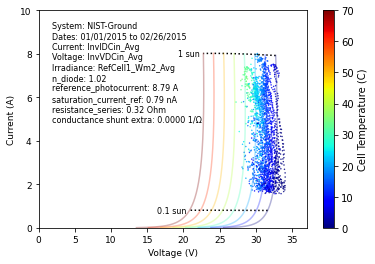

In [32]:
pvp.plot_Vmp_Imp_scatter(
        df=pvp.df[boolean_mask][:10000],
        p_plot=pvp.p0,
        figure_number=4,
        plot_imp_max=10,
        plot_vmp_max=37)

In [33]:
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'diode_factor': pvp.p0['diode_factor'],
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 365.25/24,
    'iterations_per_year': 24,
    'start_point_method': 'last',
    'save_figs_directory': save_figs_directory,
    'saturation_current_multistart': [1],
    'plot_imp_max': 10,
    'plot_vmp_max': 45,
    'save_figs': False,
    'verbose': False,
}

Execute parameter extraction:

In [34]:
ret = pvp.execute(iteration='all',
                          boolean_mask=boolean_mask,
                          **hyperparams)

100%|███████████████████████████████████████████| 95/95 [00:26<00:00,  3.63it/s]

Elapsed time: 0.44 min


Pull out results and inspect goodness of fit.

In [35]:
pfit = pvp.result['p']

In [36]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvp.plot_Vmp_Imp_scatter(df=pvp.df[cax][mask],
                             p_plot=pfit.iloc[k],
                            plot_vmp_max=37,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvp.plot_current_irradiance_mpp_scatter(df=pvp.df[cax][mask],

                                            p_plot=pfit.iloc[k],
                            plot_imp_max=10)
    plt.gcf().set_dpi(400)

    plt.show()
#     plt.savefig('figures_NIST/nist-ground-inspect-fit.png',
#                 dpi=400,
#                bbox_inches='tight')

interactive(children=(IntSlider(value=47, description='k', max=95), Checkbox(value=True, description='filter')…

## Plot Results

In [37]:
from datetime import datetime
date_saved = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
pfit = pvp.result['p']
pfit.index = pd.to_datetime(pfit['t_start'])
pfit['t_start'] = pd.to_datetime(pfit['t_start'])

pfit.dropna(inplace=True)
pfit = pfit[pfit['residual'] < np.percentile(pfit['residual'],99)]
pfit.to_csv('results_NIST/{}_{}_results.csv'.format(pvp.system_name, date_saved),
           index=False)

others = {'system_name':pvp.system_name,}
params = {**others,**hyperparams}
pd.Series(params).to_csv('results_NIST/{}_{}_params.csv'.format(pvp.system_name, date_saved))

In [38]:
yoy_result = analyze_yoy(pfit)

0.36209689049101323


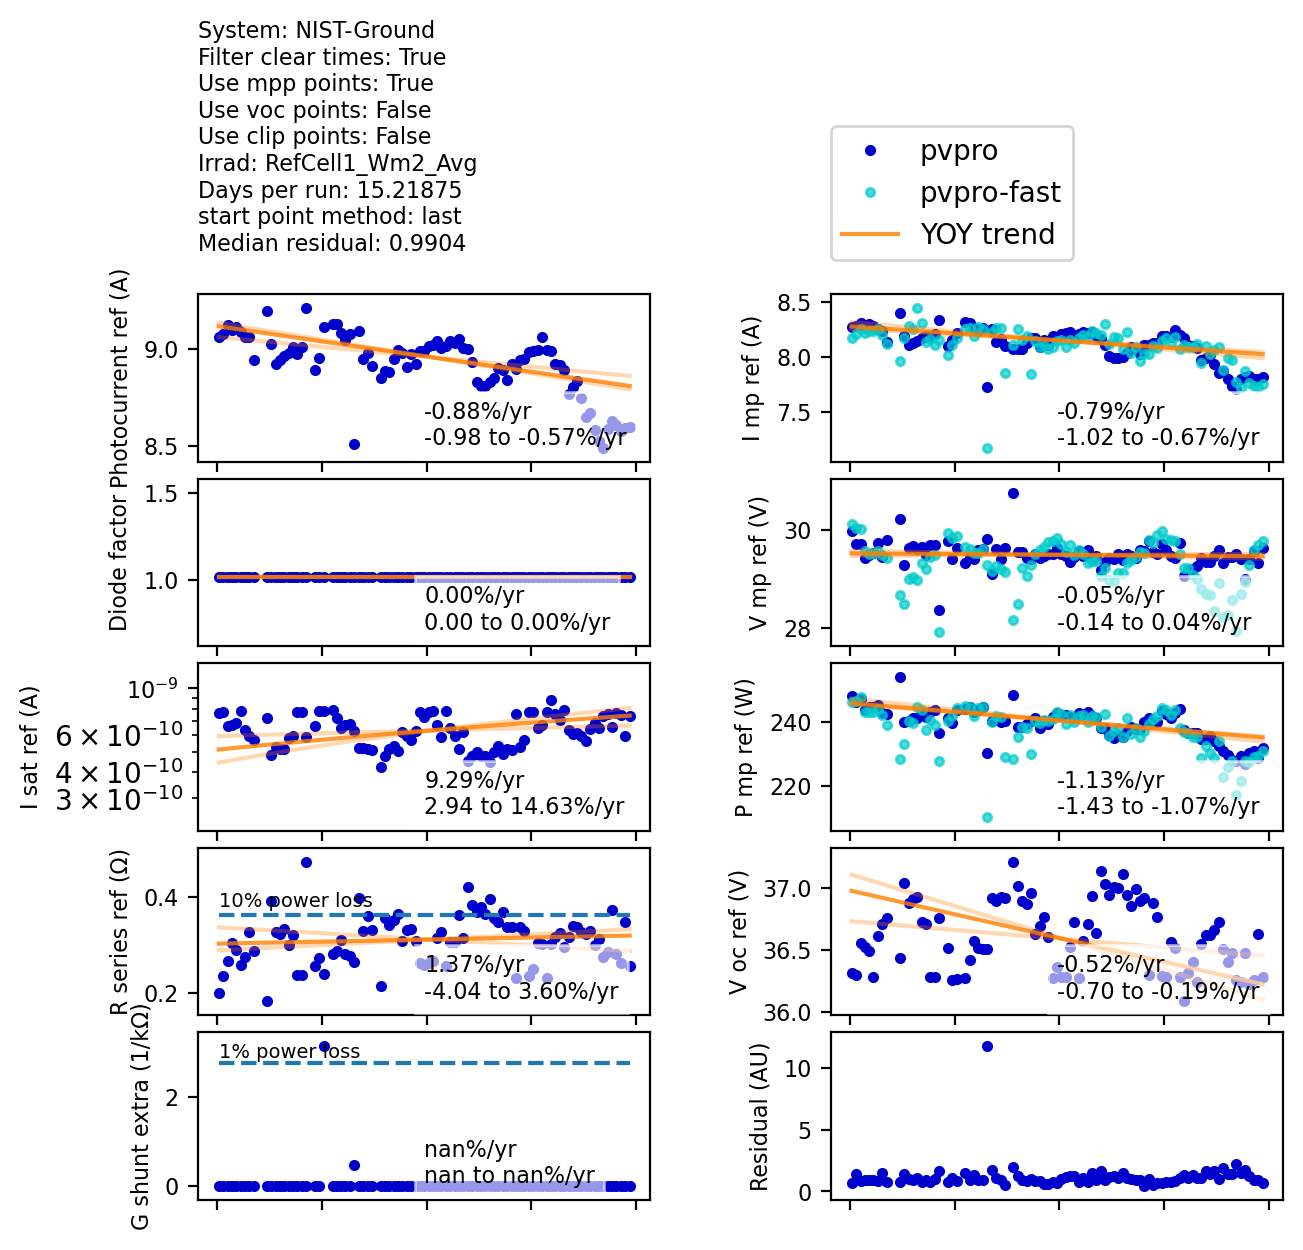

In [42]:


extra_text = 'System: {}\n'.format(pvp.system_name) + \
                 'Filter clear times: {}\n'.format(filter_clear_time) + \
                 'Use mpp points: {}\n'.format(hyperparams['use_mpp_points']) + \
                 'Use voc points: {}\n'.format(hyperparams['use_voc_points']) + \
                 'Use clip points: {}\n'.format(hyperparams['use_clip_points']) + \
                 'Irrad: {}\n'.format(pvp.irradiance_poa_key) + \
                 'Days per run: {}\n'.format(hyperparams['days_per_run']) + \
                 'start point method: {}\n'.format(hyperparams['start_point_method']) + \
                  'Median residual: {:.4f}\n'.format(1000*np.median(pfit['residual']))

plot_results_timeseries(pfit,yoy_result,extra_text=extra_text)
plt.gcf().set_dpi(200)

Inspect the smoothness of the minimum in parameter space.

In [40]:
from tqdm import tqdm
from pvpro.fit import production_data_curve_fit
# Clip dataframe shorter.
df = pre.df[-10000:-8000]

fit_params = ['diode_factor',
              'photocurrent_ref',
              'resistance_series_ref',
              'conductance_shunt_extra']

# Can set a custom startpoint if auto-chosen startpoint isn't great.
p0 = {'diode_factor': 1.10,
          'photocurrent_ref': 8.75,
          'resistance_series_ref': 0.4,
          'conductance_shunt_extra': 0.001}

saturation_current_list = np.logspace(-11,-9,20)
result = pd.DataFrame()
for j in tqdm(range(len(saturation_current_list))):
    # Run the fit
    out = production_data_curve_fit(
        temperature_cell=df[pvp.temperature_cell_key],
        effective_irradiance=df[pvp.irradiance_poa_key],
        operating_cls=df['operating_cls'],
        voltage=df[pvp.voltage_key]/pvp.modules_per_string,
        current=df[pvp.current_key]/pvp.parallel_strings,
        alpha_isc=pvp.alpha_isc,
        resistance_shunt_ref=pvp.resistance_shunt_ref,
        saturation_current_ref=saturation_current_list[j],
        p0=p0,
        cells_in_series=pvp.cells_in_series,
#         band_gap_ref=1.121,
        verbose=False,
        solver='L-BFGS-B',
        singlediode_method='fast',
        method='minimize',
        use_mpp_points=True,
        use_voc_points=False,
        use_clip_points=False,
    )
    
    result.loc[j, 'saturation_current_ref'] = saturation_current_list[j]
    for k in out['p']:
        result.loc[j,k] = out['p'][k]
    result.loc[j,'residual'] = out['residual']



100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


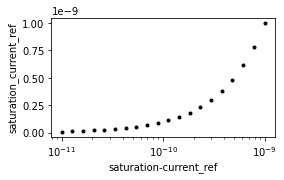

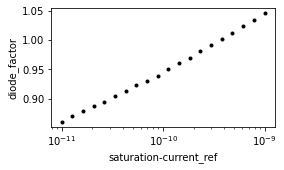

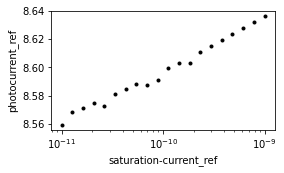

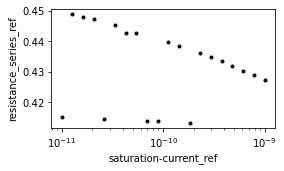

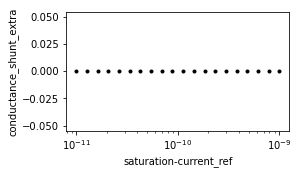

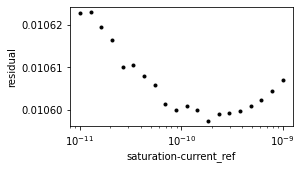

In [41]:

n=0
for k in result:
    plt.figure(n,figsize=(4,2.2))
    plt.clf()
    plt.plot(saturation_current_list, result[k],'k.',label='Fit')

#     if k in df:
#         plt.axhline(y=df[k].mean(),c='r',label='True')

#     plt.axvline(x=df['saturation_current_ref'].mean(), c='r')

    plt.xscale('log')
    plt.xlabel('saturation-current_ref')
    plt.ylabel(k)
#     plt.legend()
    plt.show()
#     plt.savefig('figures/synth05_loss_vs_saturation_{}.pdf'.format(k),
#                 bbox_inches='tight')

    n=n+1